In [1]:
from thil_utils import *
# torch.manual_seed(2016)
# np.random.seed(2016)


Using cuda device
Figure directory exists.
Model saving directory exists.


In [2]:
p = create_dataset('kappa_data.pkl',
                   apply_transforms=True)
n = create_dataset_n(img_dir = '/hpc/home/srs108/thilafushi/none_sorted_images/negative',
                    apply_transforms=True)

In [3]:
def train(model, loss, opt, epoch, dataloader, device):
    model.to(device=device)
    model.train()
    train_ious = []
    running_loss = 0
    running_acc = 0
    iou_metric = torchmetrics.IoU(num_classes=2).to(device)
        
    for i, batch in enumerate(dataloader):
        x = batch['img'].float().to(device=device)
        y = batch['fpt'].unsqueeze(dim=1).to(device=device).long()   
        output = model(x)

        output_binary = torch.zeros(output.shape).to(device)
        output_binary[output >= 0.5] = 1

        iou_score = iou_metric(output_binary.float(), y)
        train_ious.append(iou_score.item())
        
        #Accuracy
        acc_epoch = pixel_accuracy(output, y)
        running_acc += acc_epoch.item()
        
        #Binary Cross Entropy Loss
        loss_epoch = loss(output, y.float())
        running_loss += loss_epoch.item()

        opt.zero_grad()
        loss_epoch.backward()
        opt.step()
    
    return running_loss/len(dataloader), np.average(train_ious),running_acc/len(dataloader)


In [13]:
def image_comparison(imgname, ogimg, ogmask, prediction,iou, save = True, show = True, train_o_test='', fig_name =''):
    
    f, axs = plt.subplots(1, 3, figsize=(5, 5))

    axs[0].imshow(ogimg.permute(1, 2, 0))        #original image, no labels
#     axs[0].set_title('Satellite Image', fontsize=8)
    axs[0].set_yticklabels([])
    axs[0].set_xticklabels([])
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_ylabel(imgname)

    axs[1].imshow(ogmask, cmap='gray')           #ground truth label
#     axs[1].set_title('Visually Identified Plume', fontsize=8)
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap= 'gray')                      #prediction
#     axs[2].set_title('Machine Learning Output', fontsize=8)
    axs[2].axis('off')
    axs[2].text(10, 29, f'IoU:{iou}',c='w', bbox=dict(facecolor='black', edgecolor='white', boxstyle='square', pad=0.3, alpha=0.5), color='white')

    if save== True:
        f.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
    if show == True:
        plt.show()
        
    plt.close() 
    

In [14]:
def test(model, loss, dataloader, device, val_o_test = 'val'):
    model.to(device=device)
    model.eval()
    running_loss = 0
    running_acc = 0
    test_ious = []
    iou_metric = torchmetrics.IoU(num_classes=2).to(device)

    pos_only = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            x = batch['img'].float().to(device=device)
            y = batch['fpt'].unsqueeze(dim=1).to(device=device).long()
            
            output = model(x)
            output_binary = torch.zeros(output.shape).to(device)
            output_binary[output >= 0.5] = 1
            
            iou_score = iou_metric(output_binary.float(), y)
            test_ious.append(iou_score.item())
            
            rounded_iou_score = round(iou_score.item(),2)
            
#             Accuracy
            acc_epoch = pixel_accuracy(output, y)
            running_acc += acc_epoch.item()
            
#             print(acc_epoch)
            #Binary Cross Entropy Loss
            loss_epoch = loss(output, y.float())
            running_loss += loss_epoch.item()
            
            if val_o_test =='test':
                for n in range(1):
                    try:
                        
                        name = str(batch['imgfile'][n].split('/')[-1].split('_')[0][0:4]+'-'+
                             batch['imgfile'][n].split('/')[-1].split('_')[0][4:6]+'-'+
                             batch['imgfile'][n].split('/')[-1].split('_')[0][6:])
                        
                        if batch['imgfile'][n].split('/')[-2] == 'positive':
                            pos_only.append(iou_score.item())
                            image_comparison(name, batch['img'][n].cpu(), y[n][0].cpu(), output_binary[n][0].cpu(), rounded_iou_score,
                                    save=True, show=True, train_o_test='Testing', 
                                    fig_name='Test_{}_{}'.format(batch['imgfile'][n].split('/')[-2],
                                    batch['imgfile'][n].split('/')[-1].split('.')[0].split('_')[0]))

                    except Exception as e:
                        print(e)
                        continue

            torch.cuda.empty_cache()
        return running_loss/len(dataloader), np.average(test_ious), running_acc/len(dataloader), np.average(pos_only)

In [6]:
start_time = time.time()
print(start_time)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trigger_times = 0
epochs = 500
loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(19))
best_iou = 0.0 
best_model_weights = None 
patience = 100
history = {'epoch':[],'train_loss': [], 'val_loss':[], 
           'train_iou': [], 'val_iou':[], 'train_acc': [], 'val_acc':[]}

data_train =  torch.utils.data.ConcatDataset([p, n])
train_data, test_data = train_test_split(data_train, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

model = smp.Unet(encoder_name = 'resnet18', encoder_weights = 'imagenet', in_channels = 3,classes = 1, activation='sigmoid')
opt  = optim.SGD(model.parameters(), lr=0.0008392143382952937, momentum=1)

train_dl = DataLoader(train_data, batch_size=18,shuffle=True)
val_dl = DataLoader(val_data, batch_size = 18, shuffle=False, drop_last=True)
test_dl = DataLoader(test_data, batch_size = 1, shuffle=False)

18:44:43.284160


In [33]:
#TRAINING

for epoch in range(1, epochs+1):
    train_loss, train_iou, train_acc = train(model, loss, opt, epoch, train_dl, device)
    val_loss, val_iou, val_acc = test(model, loss, val_dl, device, val_o_test='val')
#     print(f"Current Train and Val IoU on epoch {epoch} : {train_iou}, {val_iou}")
    print(f'Epoch {epoch}\ntrain iou: {train_iou}\nval iou: {val_iou}\nbest iou {best_iou}')
    if val_iou > best_iou:
        trigger_times = 0
        best_iou = val_iou
        best_model_weights = model.state_dict()
        torch.save(model.state_dict(), 'best_model_weights_ag_2.pt')
        
    else: 
        trigger_times += 1
        print(f"Triggered on epoch {epoch}: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"Early stopping on epoch {epoch} - patience reached")
            break

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_acc'].append(val_acc)

df = pd.DataFrame(history)

Epoch 1
train iou: 0.18619935620914807
val iou: 0.28150749802589414
best iou 0.0
Epoch 2
train iou: 0.39159738611091266
val iou: 0.47813720703125
best iou 0.28150749802589414
Epoch 3
train iou: 0.4835805310444398
val iou: 0.48727928996086123
best iou 0.47813720703125
Epoch 4
train iou: 0.4839396964419972
val iou: 0.4871902883052826
best iou 0.48727928996086123
Triggered on epoch 4: 1/100
Epoch 5
train iou: 0.4839506989175623
val iou: 0.48719035387039183
best iou 0.48727928996086123
Triggered on epoch 5: 2/100
Epoch 6
train iou: 0.48399351266297425
val iou: 0.48719035387039183
best iou 0.48727928996086123
Triggered on epoch 6: 3/100
Epoch 7
train iou: 0.48396131938154047
val iou: 0.48719035387039183
best iou 0.48727928996086123
Triggered on epoch 7: 4/100
Epoch 8
train iou: 0.48396299508484925
val iou: 0.48719035387039183
best iou 0.48727928996086123
Triggered on epoch 8: 5/100
Epoch 9
train iou: 0.4839326766404239
val iou: 0.48719035387039183
best iou 0.48727928996086123
Triggered on e

Epoch 70
train iou: 0.7599396136674014
val iou: 0.6699558854103088
best iou 0.6760643720626831
Triggered on epoch 70: 14/100
Epoch 71
train iou: 0.7605590224266052
val iou: 0.6671935319900513
best iou 0.6760643720626831
Triggered on epoch 71: 15/100
Epoch 72
train iou: 0.7621709243817762
val iou: 0.6677866697311401
best iou 0.6760643720626831
Triggered on epoch 72: 16/100
Epoch 73
train iou: 0.7513671571558173
val iou: 0.6642370104789734
best iou 0.6760643720626831
Triggered on epoch 73: 17/100
Epoch 74
train iou: 0.7592534124851227
val iou: 0.6579458594322205
best iou 0.6760643720626831
Triggered on epoch 74: 18/100
Epoch 75
train iou: 0.7484825686974959
val iou: 0.6641432762145996
best iou 0.6760643720626831
Triggered on epoch 75: 19/100
Epoch 76
train iou: 0.7582583400336179
val iou: 0.6589085459709167
best iou 0.6760643720626831
Triggered on epoch 76: 20/100
Epoch 77
train iou: 0.7587086910551245
val iou: 0.6599981427192688
best iou 0.6760643720626831
Triggered on epoch 77: 21/100


Epoch 137
train iou: 0.8148376968773928
val iou: 0.6895512819290162
best iou 0.6940115928649903
Triggered on epoch 137: 12/100
Epoch 138
train iou: 0.8149327798323198
val iou: 0.6861247777938843
best iou 0.6940115928649903
Triggered on epoch 138: 13/100
Epoch 139
train iou: 0.8088916052471508
val iou: 0.6800093173980712
best iou 0.6940115928649903
Triggered on epoch 139: 14/100
Epoch 140
train iou: 0.7990474944764917
val iou: 0.6738502740859985
best iou 0.6940115928649903
Triggered on epoch 140: 15/100
Epoch 141
train iou: 0.7874230038036
val iou: 0.6722254753112793
best iou 0.6940115928649903
Triggered on epoch 141: 16/100
Epoch 142
train iou: 0.7891103273088281
val iou: 0.6733826041221619
best iou 0.6940115928649903
Triggered on epoch 142: 17/100
Epoch 143
train iou: 0.7932534515857697
val iou: 0.67308589220047
best iou 0.6940115928649903
Triggered on epoch 143: 18/100
Epoch 144
train iou: 0.7919783646410162
val iou: 0.6755493640899658
best iou 0.6940115928649903
Triggered on epoch 1

Epoch 204
train iou: 0.8245799351822246
val iou: 0.6898760557174682
best iou 0.7063932657241822
Triggered on epoch 204: 24/100
Epoch 205
train iou: 0.8185541304675016
val iou: 0.6898085355758667
best iou 0.7063932657241822
Triggered on epoch 205: 25/100
Epoch 206
train iou: 0.8198131946000186
val iou: 0.6871401786804199
best iou 0.7063932657241822
Triggered on epoch 206: 26/100
Epoch 207
train iou: 0.8168434311043132
val iou: 0.6877771615982056
best iou 0.7063932657241822
Triggered on epoch 207: 27/100
Epoch 208
train iou: 0.8176933147690513
val iou: 0.6895956635475159
best iou 0.7063932657241822
Triggered on epoch 208: 28/100
Epoch 209
train iou: 0.819420267235149
val iou: 0.6900457143783569
best iou 0.7063932657241822
Triggered on epoch 209: 29/100
Epoch 210
train iou: 0.8187743804671548
val iou: 0.6903459429740906
best iou 0.7063932657241822
Triggered on epoch 210: 30/100
Epoch 211
train iou: 0.8221931430426511
val iou: 0.6910375714302063
best iou 0.7063932657241822
Triggered on epo

Epoch 270
train iou: 0.8390916938131506
val iou: 0.6855782032012939
best iou 0.7063932657241822
Triggered on epoch 270: 90/100
Epoch 271
train iou: 0.8374733518470417
val iou: 0.6870628118515014
best iou 0.7063932657241822
Triggered on epoch 271: 91/100
Epoch 272
train iou: 0.839746580882506
val iou: 0.6876120686531066
best iou 0.7063932657241822
Triggered on epoch 272: 92/100
Epoch 273
train iou: 0.8375998383218591
val iou: 0.6898720741271973
best iou 0.7063932657241822
Triggered on epoch 273: 93/100
Epoch 274
train iou: 0.8405902737920935
val iou: 0.6912681937217713
best iou 0.7063932657241822
Triggered on epoch 274: 94/100
Epoch 275
train iou: 0.838133920322765
val iou: 0.6921140551567078
best iou 0.7063932657241822
Triggered on epoch 275: 95/100
Epoch 276
train iou: 0.840793785723773
val iou: 0.6910140514373779
best iou 0.7063932657241822
Triggered on epoch 276: 96/100
Epoch 277
train iou: 0.8392240513454784
val iou: 0.6912874221801758
best iou 0.7063932657241822
Triggered on epoch

train_data: 214 positives, 178 negatives

test_data: 73 positives, 50 negatives

val_data: 53 positives, 45 negatives


In [7]:
model.load_state_dict(torch.load('best_model_weights_ag_2.pt'))


<All keys matched successfully>

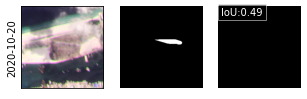

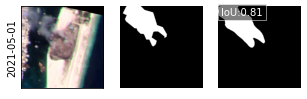

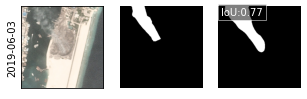

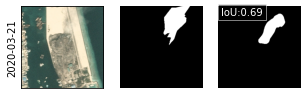

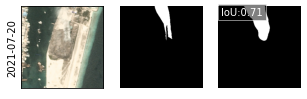

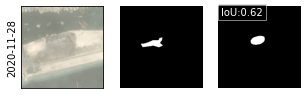

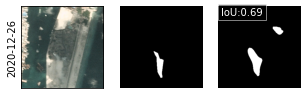

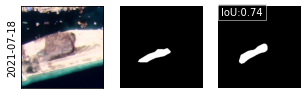

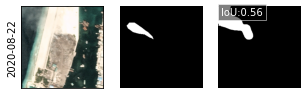

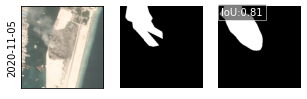

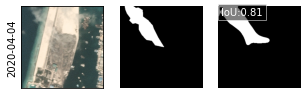

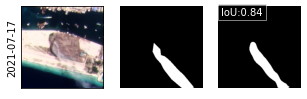

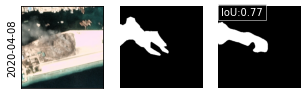

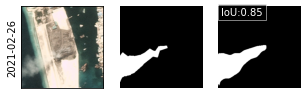

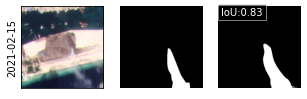

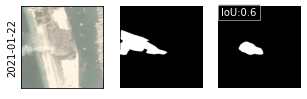

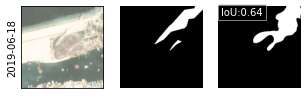

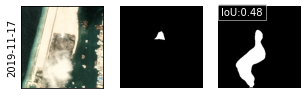

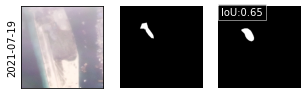

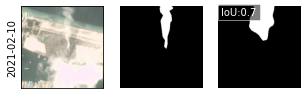

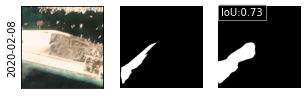

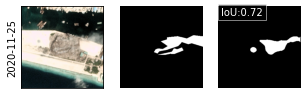

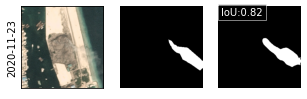

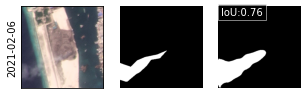

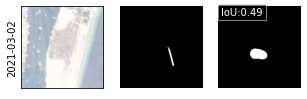

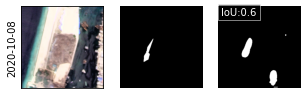

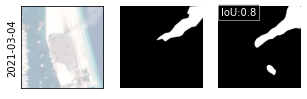

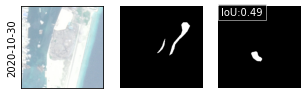

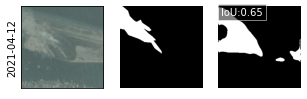

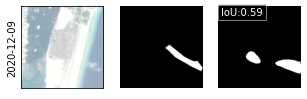

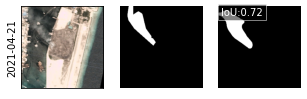

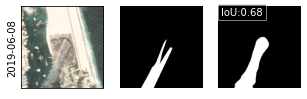

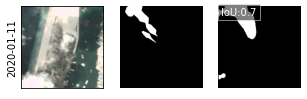

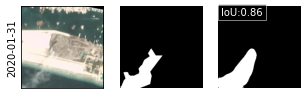

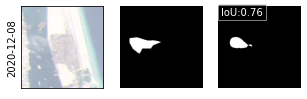

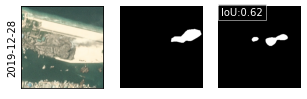

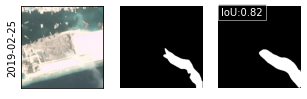

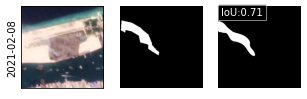

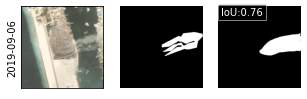

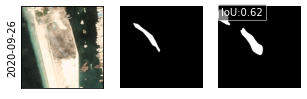

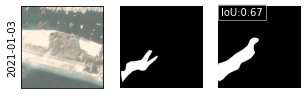

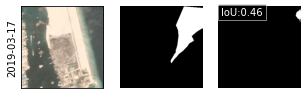

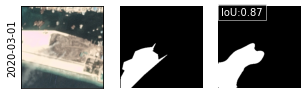

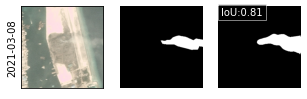

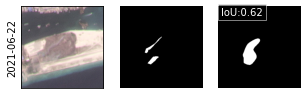

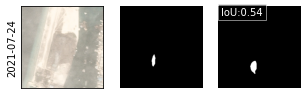

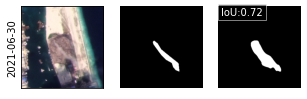

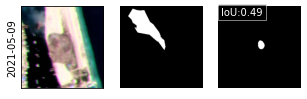

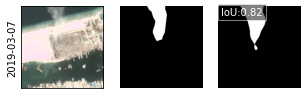

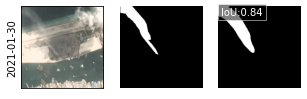

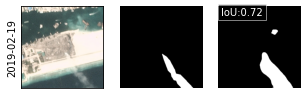

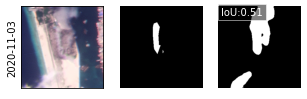

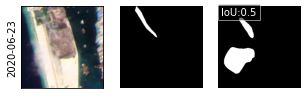

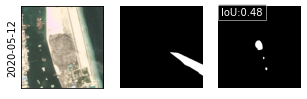

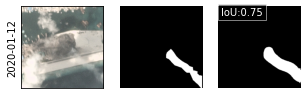

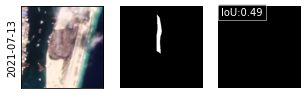

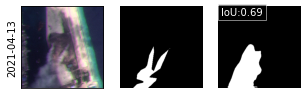

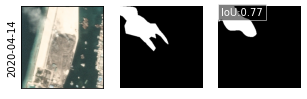

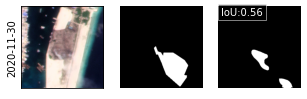

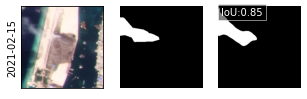

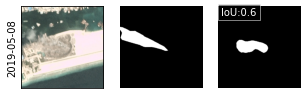

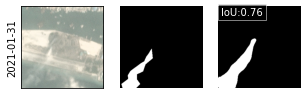

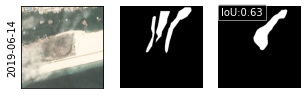

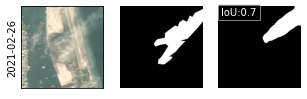

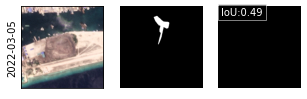

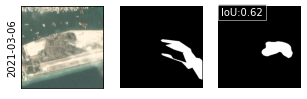

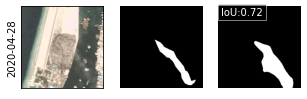

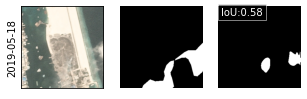

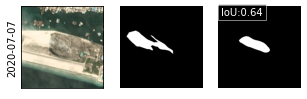

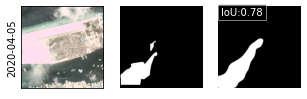

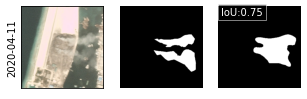

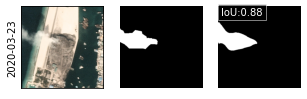

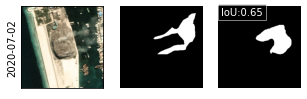

Testing IoU: 0.6084833297787643
Testing Accuracy 0.9648195427607714
Positive IOoU: 0.6836974808614548


In [15]:
# Load the best model weights and test the model
test_loss, test_iou, test_acc, pos = test(model, loss, test_dl, device, val_o_test='test')
print('Testing IoU:',test_iou)
print('Testing Accuracy',test_acc)
print('Positive IOoU:', pos)

In [11]:
pos

0.6836974808614548

In [22]:
print('Best Train IoU:',max(df['train_iou']))
print('Best Val IoU', max(df['val_iou']))
print('Best Train Accuracy:', max(df['train_acc']))
print('Best Val Accuracy:', max(df['val_acc']))

Best Train IoU: 0.8277498435000984
Best Val IoU 0.6963675022125244
Best Train Accuracy: 0.9678357632792726
Best Val Accuracy: 0.9747461477915446


# EDIT BEFORE RUNNING

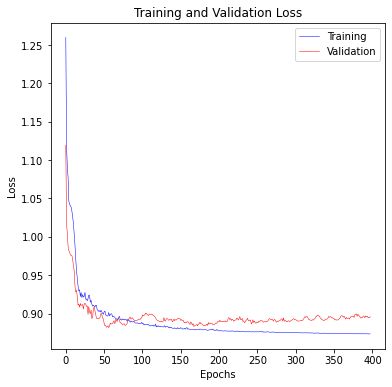

In [29]:
train_test_loss(df['train_loss'], df['val_loss'], len(df['val_loss']), save = False, fig_name='loss')

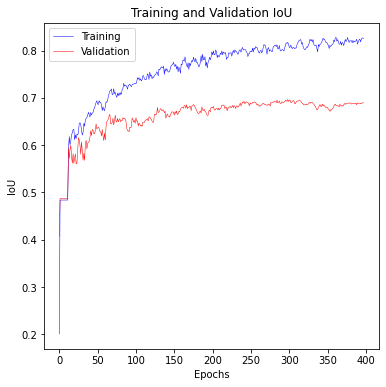

In [30]:
train_test_ious(df['train_iou'], df['val_iou'], len(df['val_iou']), save=False, fig_name='iou')

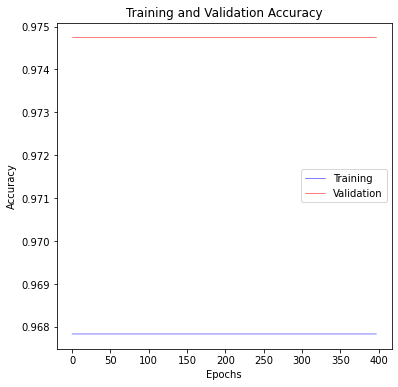

In [31]:
train_test_acc(df['train_acc'], df['val_acc'], len(df['val_acc']), save = False, fig_name='acc')

In [13]:
df.to_csv('history.csv', index=False)